<p><font size="6"><b>CASE - Argo Sea Floats</b></font></p>


> *DS Python for GIS and Geoscience*  
> *October, 2022*
>
> *© 2022, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray as xr

For this use case, we do a data exploration of the [Argo floats](https://argo.ucsd.edu/) data set, an international collaboration that collects high-quality temperature and salinity profiles from the upper 2000m of the ice-free global ocean and currents from intermediate depths.

> Argo is an international program that collects information from inside the ocean using a fleet of robotic instruments that drift with the ocean currents and move up and down between the surface and a mid-water level. Each instrument (float) spends almost all its life below the surface.

These data do __NOT represent full spatial coverage data__ (like remote sensing images), but measurements of salinity and temperature as a function of water `level` (related to the pressure). Each measurements happens at a given `date` on a given location (`lon`/`lat`).

In [2]:
import xarray as xr
argo = xr.load_dataset("./data/argo_float.nc")

In [3]:
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int32 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

__Note:__

The bold font (or * symbol in plain text output version) in the coordinate representation above indicates that level and date are 'dimension coordinates' (they describe the coordinates associated with data variable axes) while 'lon' and 'lat' are 'non-dimension coordinates'. We can make any variable a non-dimension coordinate.

The 'lon' and 'lat' coordinates are both linked to the `date` dimension, i.e. a measurement at a given `date` is done at a given location (`lon`/`lat`). As such, all data is contained in a single `xarray.DataSet`.

To get an overview, let's plot the coordinates of the available measurements and add a background map using [contextly](https://contextily.readthedocs.io/en/latest/index.html):

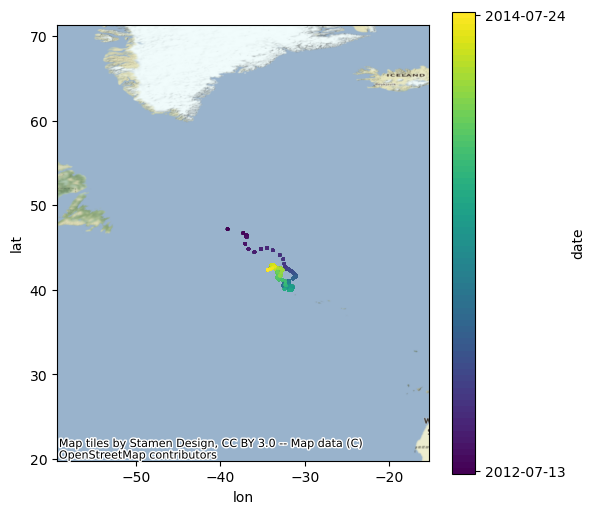

In [72]:
import contextily as cx
from pyproj import CRS
crs = CRS.from_epsg(4326)

fig, ax = plt.subplots(figsize=(6, 6))
scat = argo.plot.scatter(x='lon', y='lat', ax=ax, c='date', s=2, 
                         add_colorbar=True, add_legend=False, edgecolor=None)

# Custom adjustments of the limits, as we are in the middle of the ocean
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xlim(xmin*1.5, xmax*0.5)
ax.set_ylim(ymin*0.5, ymax*1.5)

cx.add_basemap(ax, crs=crs.to_string())

# small 'hack' to overcome the overload of ticklabels on the colorbar
current_ticks = ax.collections[0].colorbar.get_ticks()
d_dates = np.datetime_as_string(argo.date.data, unit='D')
ax.collections[0].colorbar.set_ticks(
    ticks=[current_ticks[0], current_ticks[-1]], 
    labels=[d_dates[0], d_dates[-1]]
)

<div class="alert alert-success">

**EXERCISE**:

Add a new variable to the `argo` data set, called `temperature_kelvin`, by converting the temperature to Kelvin. 
    
$T_{K} = T_{^{\circ}C} + 273.15$
   
<details>
    
<summary>Hints</summary>

* Remember that xarray works as Numpy and relies on the same broadcasting rules.

</details>    
    
</div>

In [66]:
argo["temperature_kelvin"] = argo["temperature"] + 273.15

<div class="alert alert-success">

**EXERCISE**:

The water level classes define different water depth (level). The pressure is a proxy for the water depth. Verify the relationship between the pressure and the level using a scatter plot. Does a larger value for the level represent deeper water depths or not?
    
<details><summary>Hints</summary>

* If you get the error `ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)`. When encountering an Error, always check the output message at the end of the error statement.
* The default `plot` function of xarray currently adds the `date` dimension with a color scale (and colorbar with a lot of labels). There is no direct way to overcome this with the plot function itself, see discussion at https://github.com/pydata/xarray/discussions/7268. 
* In order to overcome this, stacking the dimensions into a single dimension before ploting `argo.stack(stacked_dim=["date", "level"]).plot...` overcomes the auto-color mapping of date dimension. 
* Note that the direct usage of Matplotlib scatter function does not work out of the box when combining the `level` coordinate (78 values) data with the pressure measured data (78 by 75 values, i.e. 78 values for each of the 75 dates). Something like `plt.scatter(argo.pressure, np.broadcast_to(argo.level, argo.pressure.T.shape).T)` would work (repeating data of level to make both of matching shape).

</details>    
    
</div>

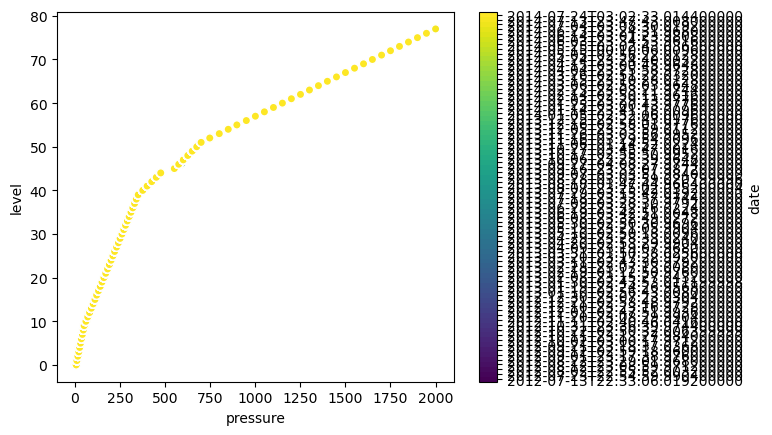

In [169]:
argo.plot.scatter(x="pressure", y="level") # adds date as additional hue-mapping.  

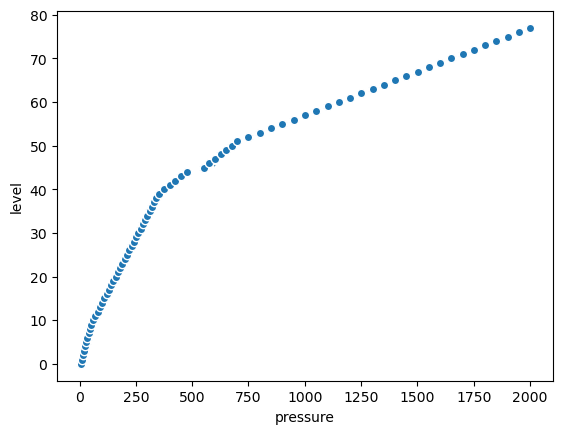

In [171]:
argo.stack(stacked_dim=["date", "level"]).plot.scatter(x="pressure", y="level")  # see https://github.com/pydata/xarray/discussions/7268#discussioncomment-4090308

<div class="alert alert-success">

**EXERCISE**:

Assume that buoyancy (in dutch _'drijfvermogen'_, it is the upward force exerted by a fluid that opposes the weight of a partially or fully immersed object) is defined by the following formula:
    
$$g \cdot ( 2\times 10^{-4} \cdot T - 7\times 10^{-4} \cdot P )$$

With:
- $g$ = 9.8
- $T$ = temperature
- $P$ = pressure

Calculate the buoyancy and add it as a new variable `buoyancy` to the `argo` data set. 

Make a 2D (image) plot with the x-axis the date, the y-axis the water level and the color intensity the buoyancy. As the level represents the depth of the water, it makes more sense to have 0 (surface) at the top of the y-axis: switch the y-axis direction.
    
<details><summary>Hints</summary>

* $2\times 10^{-4}$ can be written in Python as `2e-4`
* Remember that xarray works as Numpy and relies on the same broadcasting rules.
* The `imshow` method does not work on irregular intervals. Matplotlib and xarray also have `pcolormesh`.    
* Look for options [in the xarray documentation](http://xarray.pydata.org/en/stable/plotting.html#other-axes-kwargs) to control the axis direction. (The `ax.invert_yaxis()` Matplotlib function is not supported for pcolormesh)
    
</details>    
    
</div>

In [172]:
argo["buoyancy"] = 9.8 * (2e-4 * argo["temperature"] - 7e-4 * argo["pressure"])

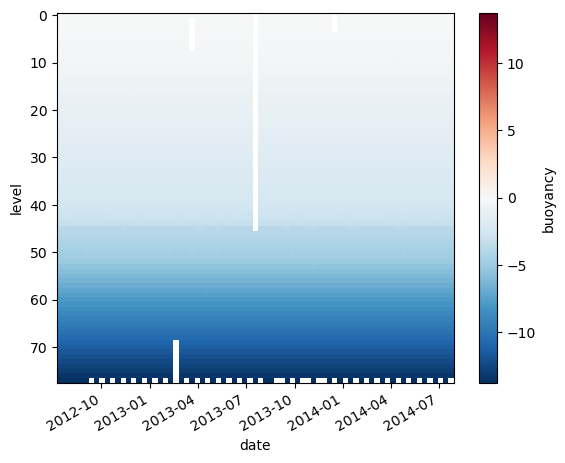

In [173]:
argo["buoyancy"].plot(yincrease=False)  # xarray decides the plot type when no specific method is used

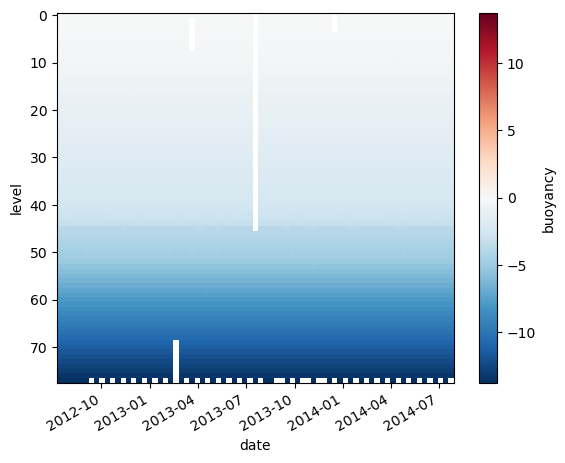

In [174]:
# More explicit version defining the x and y axis
argo["buoyancy"].plot.pcolormesh(x="date", y="level", yincrease=False)  # pcolormesh instead of imshow

<div class="alert alert-success">

**EXERCISE**:

Make a line plot of the salinity as a function of time at level 10
   
<details><summary>Hints</summary>

Break it down into different steps and chain the individual steps:
    
* From the argo data set, select the variable `salinity`. This is similar to selecting a column in Pandas.
* Next, use the `sel` method to select the `level=10`
* Next, use the `plot.line()` method.

</details>    
    
</div>

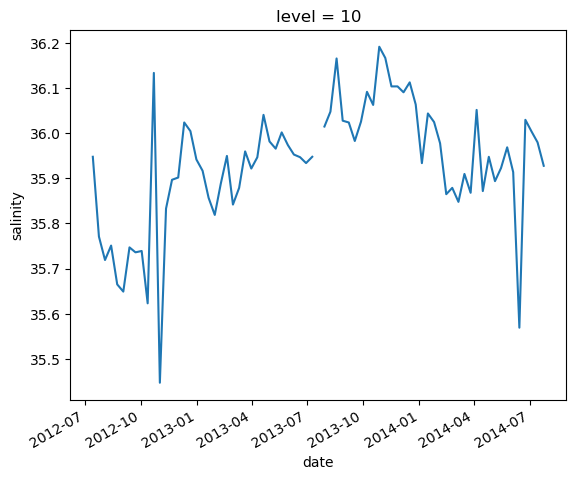

In [175]:
argo["salinity"].sel(level=10).plot.line()

<div class="alert alert-success">

**EXERCISE**:

- Make a line plot of the temperature as a function of time for the levels 10, 20 and 30 at the same graph 
- Make a second line plot with each of the 3 levels (10, 20, 30) in a different subplot. 
   
<details><summary>Hints</summary>

Break it down into different steps and chain these individual steps:
    
* From the argo data set, select the variable `temperature`. This is similar to selecting a column in Pandas.
* Next, use the `sel` method to select the levels 10, 20 and 30.
* Next, use the `plot.line()` method, but make sure the `hue` changes for each level
    
For the subplots, check the [facetting documentation](http://xarray.pydata.org/en/stable/plotting.html#faceting) of xarray. 

</details>    
    
</div>

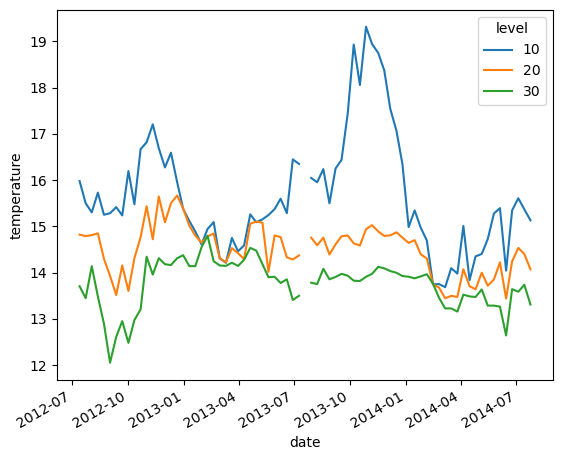

In [176]:
argo["temperature"].sel(level=[10, 20, 30]).plot.line(hue="level");

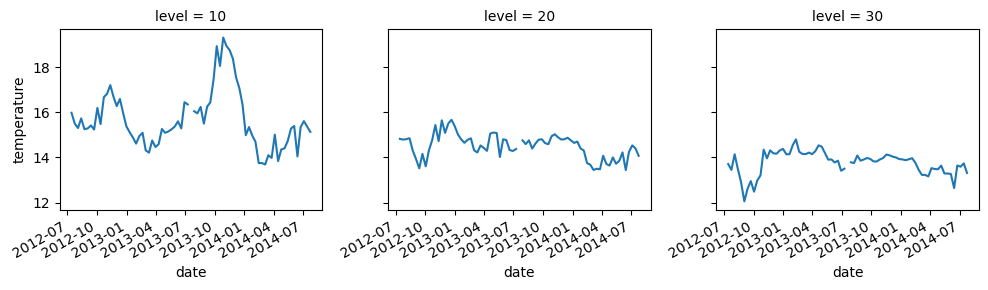

In [177]:
argo["temperature"].sel(level=[10, 20, 30]).plot.line(col="level");

<div class="alert alert-success">

**EXERCISE**:

You wonder how the temperature evolves with increasing latitude and what the effect is of the depth (level):

- Create a scatter plot of the `level` as a function of the `temperature` colored by the `latitude`. 
    
- As a further exploration step, pick a subset of levels 1, 10, 25, and 50 and create a second scatter plot with in the x-axis the latitude of the measurement and in the y-axis the temperature. To compare the effect of the different levels, give each level a separate subplot next to each other.
   
<details><summary>Hints</summary>

* In a scatter plot, the color or `hue` can be linked to a variable (instead of the deafult `date`).
* From the argo data set, use the `sel` method to select the levels 1, 10, 25, and 50.
* For the second scatter plot, but make sure the `col` changes for each `level` and define which variables need to go to which axis.
* Hide the colorbar (has no usage, but is shown) with the `add_colorbar=False` parameter OR add the mapping of temperature as well.

</details>    
    
</div>

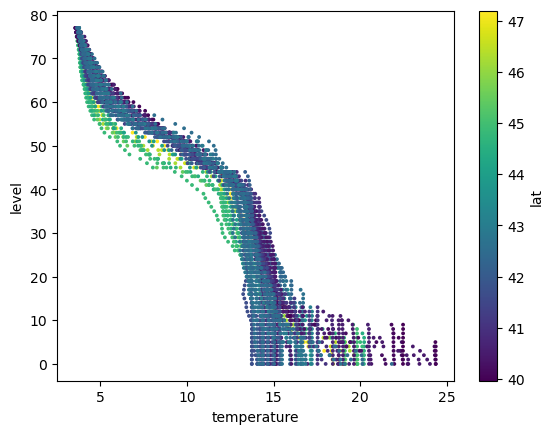

In [196]:
argo.plot.scatter(x="temperature", y="level", s=3,
                  hue="lat", edgecolor=None)

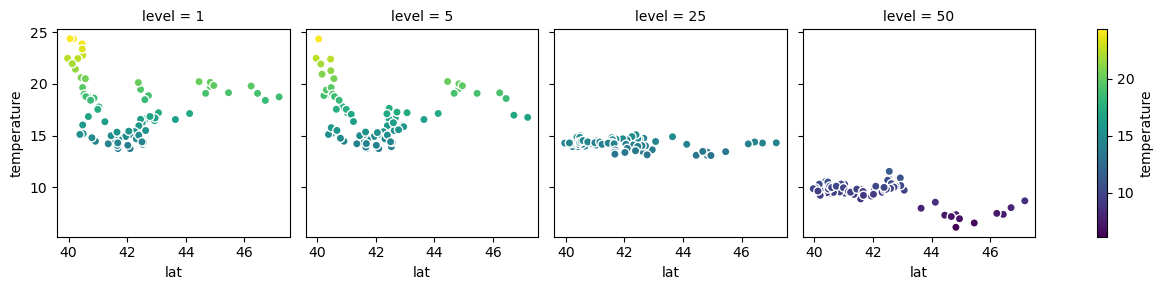

In [214]:
argo.sel(level=[1, 5, 25, 50]).plot.scatter(x="lat", y="temperature", 
                                            col="level", hue="temperature")

<div class="alert alert-success">

**EXERCISE**:

Make an image plot of the temperature as a function of time. Divide the colormap in 3 discrete categories using xarray plot methods:
    
* x < 5
* 5 < x < 15
* x > 15
    
Choose a custom colormap and adjust the label of the colorbar to `'Temperature (°C)'`
   
<details>
    
<summary>Hints</summary>

- Check the help of the `plot` function or the [xarray documentation](http://xarray.pydata.org/en/stable/plotting.html#discrete-colormaps) on discrete colormaps.
- Adjustments to the colorbar settings can be defined with the `cbar_kwargs` as a dict. Adjust the `label` of the colorbar.    

</details>    
    
</div>

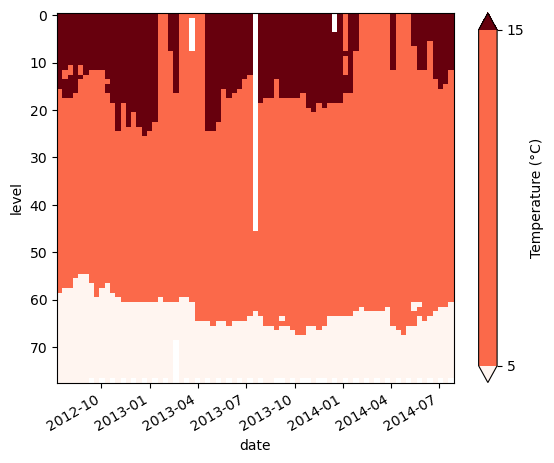

In [215]:
argo.temperature.plot.pcolormesh(yincrease=False, 
                                 cbar_kwargs={'label': 'Temperature (°C)'},
                                 cmap='Reds',
                                 levels=[5, 15]
                                );

<div class="alert alert-success">

**EXERCISE**:

Plot a salinity profile, i.e. how the salinity evolves with the depth/level, for the measurement done at 2012-10-31. Add two lines to the plot:
    
- The salinity data of 2012-10-31 with the salinity in the x-axis and the level in the y-axis.
- The salinity data of 2012-10-31 with the level in the y-axis, but using a rolling median value for the level coordinate using 10 levels (with `center=True` to make the two plots comparable) to smooth the data. 
    
Feel free to adjust the settings of both lines (color, width,...
    
<details><summary>Hints</summary>
    
* Use `fig, ax = plt.subplots()` to prepare a Figure/axes fo both lines.
* The `rolling` method need to be applied to the `level` coordinate.
* You can pass configuration options such as `linewidth`, `color`,... to the line plot method.

</details>    
    
</div>

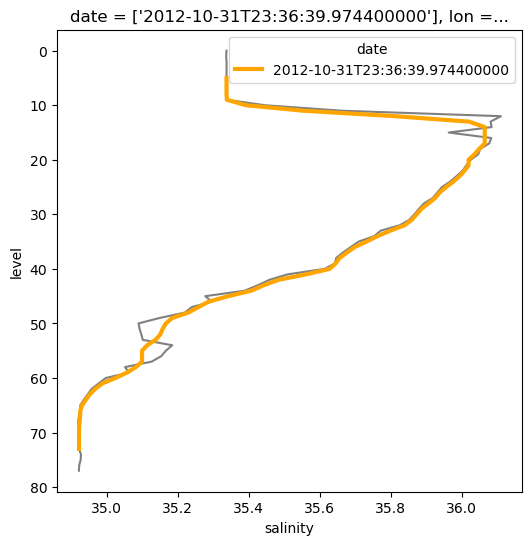

In [216]:
salinity_20121031 = argo["salinity"].sel(date='2012-10-31')

fig, ax = plt.subplots(figsize=(6, 6))
salinity_20121031.plot.line(y="level", yincrease=False, color="grey");
salinity_20121031.rolling(level=10, center=True).median().plot.line(y="level", yincrease=False, linewidth=3, color="orange");

<div class="alert alert-success">

**EXERCISE**:

An improved version of the salinity profile of the previous exercise uses the `pressure` data instead of the levels, plotting the pressure-salinity relationship. In the current data representation the pressure is a data variable. However, it can also be interpreted as a coordinate, i.e. the depth of the measurement (see exercise on the relation between pressure and level. 
    
To create a salinity and temperature profile for each of the measurements in December 2012, convert the `pressure` variable to a coordinate instead of a data variable first. Prepare two subplots with Matplotlib to plot respectively the salinity and the temperature profile for each of the measurements in December 2012.  Use the pressure in the y-axis and make sure pressure increases from top to bottom of the graph.   
    
    
<details><summary>Hints</summary>
    
* Use `assign_coords` to use the pressure as coordinate data.
* Do not forget to select all measurements of December 2012, e.g. using the string representation `.sel(date='2012-12')`
* You can directly create two axes objects with matplotlib: `fig, (ax0, ax1) = plt.subplots(1, 2)`
</details>    
    
</div>

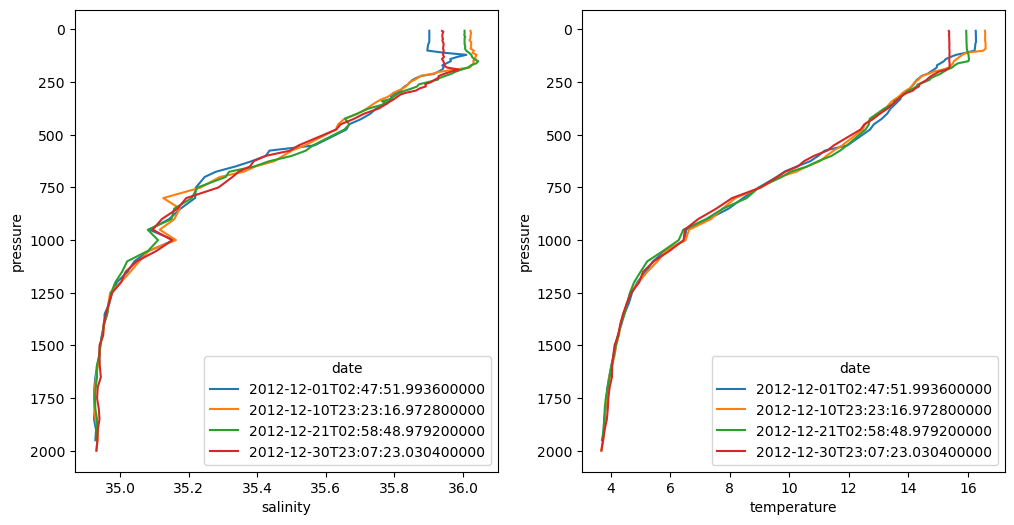

In [218]:
argo_pressure = argo.assign_coords(pressure=argo["pressure"]).sel(date='2012-12')

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
argo_pressure["salinity"].plot.line(y="pressure", yincrease=False, ax=ax0, hue='date');
argo_pressure["temperature"].plot.line(y="pressure", yincrease=False, ax=ax1, hue='date');

<div class="alert alert-success">

**EXERCISE**:

Calculate the average salinity and temperature as a function of level over the measurements taken between 2012-10-01 and 2012-12-01. 

Make a separate line plot for each of them. Define the Figure and 2 subplots with Matplotlib first. 
    
<details><summary>Hints</summary>

* xarray supports to query dates using a string representation.
* Use the `slice` operator within the `sel` to select a range of the data.
* Whereas in Numpy we used `axis` in reduction functions, xarray uses the `dim` name.
* Also for line plots you can define which dimension should be on the x-axis and which on the y-axis by providing the name.  
* Use `fig, (ax0, ax1) = plt.subplots(1, 2)` to create subplots.
</details>    
    
</div>

In [219]:
subset_mean = argo.sel(date=slice('2012-10-01', '2012-12-01')).mean(dim="date")

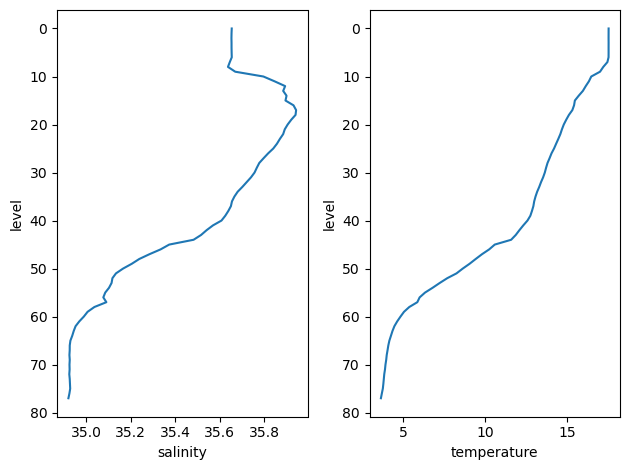

In [220]:
fig, (ax0, ax1) = plt.subplots(1, 2)
subset_mean["salinity"].plot.line(y="level", yincrease=False, ax=ax0)
subset_mean["temperature"].plot.line(y="level", yincrease=False, ax=ax1)
plt.tight_layout()